# Set up

In [ ]:
# Establish connection to drive
from google.colab import drive
drive.mount('/content/drive')
root_path = 'drive/MyDrive/Colab Notebooks'

In [1]:
!pip install pypdfium2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 32.5 MB/s eta 0:00:00


# Latin alphabets
(General approach first tested on latin alphabets)

In [2]:
# Load pdf
import pypdfium2 as pdfium
pdf = pdfium.PdfDocument("./Apple_font_mapping_issue.pdf")
#version = pdf.get_version()
print("Number of pages in pdf: ", len(pdf))

Number of pages in pdf:  1


In [3]:
#Get unique characters and their indexes from text_str
def get_unique_characters_with_index(txt_string):
  # Dictionary to store unique characters and their first occurrence index
  unique_chars = {}

  unwanted_chars = ['\n', '\r', ' ']

  for index, char in enumerate(txt_string):
      # Add the character to the dictionary if it's not already present
      if char not in unique_chars and char not in unwanted_chars:
          unique_chars[char] = index

  return unique_chars

def get_coord_pixel(dtp_coord):
  return (96*dtp_coord)/72

In [4]:
def get_page_character_glyphs(pdf_page):
    pg_w, pg_h = pdf_page.get_size()
    txtpg = pdf_page.get_textpage()

    # Get text on page
    text_str = txtpg.get_text_range()
    # Get unique characters with index on page
    unique_char = get_unique_characters_with_index(text_str)

    img_scale = 2
    # Render the page in form of an image with actual page dimesnsions being translated to image dimensions
    pil_image = pdf_page.render(scale=(96/72)*img_scale).to_pil()

    glyph_images = {}

    for char in unique_char.keys():
        # get_charbox returns binding box with coordinates in seq: left, bottom, right, top
        # But if the origin is considered to be at left top corner (used in images)
        # Then, the bottom coordinate will correspond to top in the image and vice-versa
        left, bottom, right, top = txtpg.get_charbox(unique_char[char])

        # Get page size to properly orient the y-axis for image
        left_px = get_coord_pixel(left)
        top_px = get_coord_pixel(pg_h-top)
        right_px = get_coord_pixel(right)
        bottom_px = get_coord_pixel(pg_h-bottom)

        #print(left_px, top_px, right_px, bottom_px)

        # Crop the glyph from the page image
        glyph_images[char] = pil_image.crop((left_px*img_scale, top_px*img_scale, right_px*img_scale, bottom_px*img_scale))

    return glyph_images


## Get unicode for glyphs

In [5]:
import config
import os
import PIL.Image

# Configure API Key
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown
import textwrap

def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

genai.configure(api_key=config.GEMINI_API_KEY)

In [6]:
def get_unicode_from_gemini(glyph_img):
  # Initialise model
  model = genai.GenerativeModel("gemini-1.5-flash")

  # Pass image and prompt
  response = model.generate_content(
      [
          "The given picture has a character in it. Return the correct unicode for that character. Do not add any other unnecessary information.",
          glyph_img,
      ],
      stream=True,
  )
  response.resolve()
  return response.text.strip()

In [8]:
# Get the first page of pdf
pdf_page = pdf[0]

# Get the glyphs of all unique characters in the page
glyph_images = get_page_character_glyphs(pdf_page)

# Unique characters (as read by the pypdfium2 parser)
print(glyph_images.keys())

dict_keys(['A', 'p', 'l', 'e', 'I', 'n', 'c', '.', 'C', 'O', 'N', 'D', 'E', 'S', 'L', 'T', 'M', 'F', 'P', 'R', '(', 'U', 'a', 'u', 'd', 'i', 't', ')', 'm', 'o', 's', ',', 'x', 'b', 'r', 'f', 'h', 'w', '-', '3', '0', '2', '4', '1', ':', '!', '6', '8', '7', '9', 'v', '5', 'G', 'g', '/', 'B', 'y', 'J', 'W', 'H'])


/usr/local/lib/python3.10/dist-packages/pypdfium2/_helpers/textpage.py:80: UserWarning: get_text_range() call with default params will be implicitly redirected to get_text_bounded()
  warnings.warn("get_text_range() call with default params will be implicitly redirected to get_text_bounded()")


In [ ]:
import time
# Get unicode for each glyph and replace in dictionary
glyph_char_map = {}
iter = 0
for char in glyph_images.keys():
  glyph_char_map[char] = get_unicode_from_gemini(glyph_images[char])
  # Introduce delay to stay within the limit of 15RPM
  time.sleep(5)

In [10]:
glyph_char_map

{'A': 'U+0041',
 'p': 'U+0070',
 'l': 'U+25A0 ◼️',
 'e': 'U+0065',
 'I': 'U+25A0',
 'n': 'U+0074',
 'c': 'U+0043',
 '.': 'U+25A0',
 'C': 'U+0043',
 'O': 'U+006F',
 'N': 'U+004E',
 'D': 'U+0044',
 'E': 'U+0045',
 'S': 'U+0053',
 'L': 'U+004C',
 'T': 'U+0054',
 'M': 'U+004D',
 'F': 'U+0046',
 'P': 'U+0050',
 'R': 'U+0052',
 '(': 'U+25C7',
 'U': 'U+0055',
 'a': 'U+0045',
 'u': 'U+2502',
 'd': 'U+0061',
 'i': 'U+2500',
 't': 'U+253C 十字',
 ')': 'U+25F2',
 'm': 'U+004D',
 'o': 'U+004F',
 's': 'U+0053',
 ',': 'U+2502',
 'x': 'U+2715',
 'b': 'U+0062'}

Sample code for unicode to character conversion

In [27]:
import unicodedata

# Convert unicode to actual character
unicode_from_VLM = glyph_char_map['M']
unicode_int = int(unicode_from_VLM[2:], 16)
# Get the character represented by the Unicode code point
character = chr(unicode_int)
print(character)

M


# Parsing Hindi Text

In [12]:
import pypdfium2 as pdfium
hindi_pdf = pdfium.PdfDocument("./hindi_text_file.pdf")
print("Number of pages in pdf: ", len(hindi_pdf))

Number of pages in pdf:  2


In [14]:
# Get the first page
first_page = hindi_pdf[0]
txtpg = first_page.get_textpage()
hindi_txt = txtpg.get_text_range()
# Hindi text parsed by the library
hindi_txt

'1\r\nहिमालय की संरचना और इसका भ\r\nू\r\nगर्भकि इतििास\r\nपीटर मोलनार\r\nदन\r\nु\r\nिया की सबसे ऊँ ची पर्तव श्\r\nर\r\nृंखला का निर्ावण आज से 4 से 5 \r\nकरोड़ र्र्व प\r\nू\r\nर्व जब भारतीय उपर्हाद्र्ीप एशिया से टकराया, उस \r\nसर्य से ही ि\r\nु\r\nरू हो गया।\r\nकरीब 40 शर्शलयि र्र्ों से भारतीय उप-र्हाद्र्ीप एशिया के भीतर धीरे-धीरे घ\r\nुसपैठ\r\nकरता रहा है। इस प्रक्रिया र्ें इसिे हहर्ालय और नतब् बत के पठार का निर्ावण क्रकया और \r\nअपिे रास् ते र्ें पड़िे र्ाले चीि और र्ृंगोशलया के टुकड़़ों को दबोच हदया। नतब्बती पठार \r\nदन\r\nु\r\nिया का सबसे ऊॅंचा और बड़ा पठार ही शसर्व भारतीय उपर्हाद्र्ीप की िक्तत और \r\nदृढ़ता का प्रतीक िहीृं है, बक्कक उप-र्हाद्र्ीप और एशिया के बीच हुई टतकर का सबसे \r\nिािदार पररणार् और वर्श्र् की सबसे ऊँची पर्तव श्ृंख\r\nर\r\nला है, क्जसे हर् सब हहर्ालय के \r\nिार् से प\r\nु\r\nकारते है।\r\nर्ह चट्टाि क्जससे हहर्ालय का निर्ावण हुआ, र्ह अपिे पीछे नतब्बती पठार के \r\nसहारे से लगातार ऊपर और भारत के र्ैदािी भाग की ओर बढ़ रही है। प्रत्येक बड़े \r\nभूकम्प के बाद का लगभग दो

In the above text, some of the words are incorrectly parsed and characters like \r \n are introduced where they shouldn't be.
The sequence of characters is also changed.



In [15]:
# Bounding boxes for हि
# consonant
trial_bbox = txtpg.get_charbox(3)
print(trial_bbox)
# matra
trial_nxt = txtpg.get_charbox(4)
print(trial_nxt)

(74.30400085449219, 730.5399780273438, 90.13716125488281, 750.76513671875)
(81.14399719238281, 727.2899169921875, 93.92471313476562, 744.9237670898438)


## Get unique hindi characters
Here, a character comprises letter + matra(if present) together.

In [16]:
# Function to get list of all characters in a page
def get_unique_characters(pdf_text):
    # Initialise a dictionary to store character : bounding box
    unique_char = {}
    seq_char = []
    prev_char = pdf_text[0]
    c_char = prev_char
    p_left, p_bottom, p_right, p_top = txtpg.get_charbox(0)
    c_left, c_bottom, c_right, c_top = txtpg.get_charbox(0)
    i_prev = 0
    c_len = 0
    for i, char in enumerate(pdf_text):
        #char = pdf_text[i]
        if char=='\n' or char=='\r' or char==' ' or i==0:
          seq_char.append(char)
          continue
        # Get bounding box for current character
        left, bottom, right, top = txtpg.get_charbox(i)
        if c_len<2 and ((p_left <= left < p_right) or (p_bottom<= bottom <= p_top)):
          # The character is likely a matra attached to prev letter
          # Get bounding box for combined characters
          c_left = min(left, p_left)
          c_bottom = min(bottom, p_bottom)
          c_right = max(right, p_right)
          c_top = max(top, p_top)
          c_char += char
          c_len += 1
        else:
          # The character is a new character
          # Add the accumulated character/s to the dictionary
          if c_char not in unique_char:
            unique_char[c_char] = (c_left, c_bottom, c_right, c_top)
          seq_char.append(c_char)
          # Reset the accumulated character
          c_char = char
          c_len = 1
        # Update previous character to current
        i_prev = i
        prev_char = char
        p_left, p_bottom, p_right, p_top = left, bottom, right, top
    return unique_char, seq_char

In [17]:
# Get unique characters
unique_characters, sequenced_characters = get_unique_characters(hindi_txt)

In [18]:
unique_characters.keys()

dict_keys(['1', 'हि', 'मा', 'लय', 'की', 'सं', 'रच', 'ना', 'और', 'इस', 'का', 'भू', 'गर', '्भ', 'कि', 'इत', 'िि', 'ास', 'पी', 'टर', 'मो', 'लन', 'ार', 'दन', 'ु', 'िय', 'ाक', 'ी', 'सब', 'से', 'ऊँ', 'ची', 'पर', '्त', 'व', 'श्', 'रृ', 'ंख', 'ला', 'नि', 'र्', 'ाव', 'ण', 'आज', '4', '5', 'कर', 'ोड', '़र', '्र', '्व', 'पू', 'जब', 'भा', 'रत', 'ीय', 'उप', 'हा', 'द्', 'ीप', 'एश', 'ा', 'टक', 'रा', 'या', ',उ', 'स', 'सर', '्य', 'ही', 'िु', 'रू', 'हो', 'गय', 'ा।', 'ीब', '0श', 'शल', 'यि', 'ों', '-', 'े', 'भी', 'तर', 'धी', 'रे', 'घु', 'सप', 'ै', 'ठ', 'ता', 'रह', 'है', '।', 'प्', 'रक', '्े', 'ं', 'िे', 'हह', 'ाल', 'य', 'नत', 'ब्', 'बत', 'के', 'पठ', 'णक', 'कय', 'अप', 'स्', 'ते', 'ें', 'पड', '़ि', 'ि', 'ृं', 'गो', 'ट', 'ुक', 'ड', '़़', 'को', 'दब', 'ोच', 'हद', 'ठा', 'रद', 'न', 'ब', 'ऊ', 'ॅ', 'ंच', 'बड', '़ा', 'शस', 'वभ', 'ती', 'यउ', 'प', 'िक', 'तऔ', 'ृ', 'ढ़', 'ीक', 'िह', 'ीृ', 'ंह', ',ब', 'क्', 'कक', '-र', '्', 'ीच', 'हु', 'ईट', 'त', 'िा', 'िद', 'रण', '्औ', 'र', 'वर', '्श', 'ँ', 'वश', '्ृ', ',क', '्ज', 'ह',

## Glyphs for hindi characters

Page is rendered as image.

1.   Page is rendered as image
2.   Coodinate of character stored in unique_characters retireved
3.   Appropriate conversions are applied to convert PDF coordinates (dtp) to image coordinates (pixels) as the axis orientation is different
4.   Glyph extracted by cropping it out from image




In [20]:
def get_hindi_glyph(bbox):
  #bbox_dtp = txtpg.get_charbox(5)
  #print(bbox)

  def get_coord_pixel(dtp_coord):
    return (96*dtp_coord)/72

  # get_charbox returns binding box with coordinates in seq: left, bottom, right, top
  # But if the origin is considered to be at left top corner (used in images)
  # Then, the bottom coordinate will correspond to top in the image and vice-versa
  left, bottom, right, top = bbox

  # Get page size to properly orient the y-axis for image
  pg_w, pg_h = first_page.get_size()
  left_px = get_coord_pixel(left)
  top_px = get_coord_pixel(pg_h-top)
  right_px = get_coord_pixel(right)
  bottom_px = get_coord_pixel(pg_h-bottom)

  print(left_px, top_px, right_px, bottom_px)

  img_scale = 2
  # Render the page in form of an image with actual page dimesnsions being translated to image dimensions
  pil_image = first_page.render(scale=(96/72)*img_scale).to_pil()

  # Crop the glyph from the page image
  glyph_image = pil_image.crop((left_px*img_scale, top_px*img_scale, right_px*img_scale, bottom_px*img_scale))

  return glyph_image

99.07200113932292 121.53987630208333 125.23295084635417 152.84016927083334


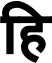

In [21]:
# Example of correctly parsed text
sample_1 = get_hindi_glyph(unique_characters['हि'])
sample_1

516.031982421875 121.53987630208333 563.8302815755209 148.50675455729166


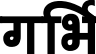

In [22]:
# For letters in incorrect sequence, the glyph includes unwanted or even incorrect infromation
sample_2 = get_hindi_glyph(unique_characters['गर'])
sample_2

556.7926432291666 120.92496744791667 590.9645182291666 148.50675455729166


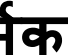

In [23]:
# Example of mismatch die to incorrect sequence of characters
sample_3 = get_hindi_glyph(unique_characters['कि'])
sample_3